**Analysis of Rotator Trajectory and Controller**

**Import Modules**

In [1]:
%matplotlib inline
%matplotlib widget
from datetime import datetime
import time
from astropy.time import Time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from lsst_efd_client import EfdClient

**Custom Functions**

In [2]:
def retrieve_efd_client(is_summit=True):
    """
    Retrieves a client to EFD.

    Parameters
    ----------
    is_summit : bool, optional
        This notebook is running on the summit or not. If not, the returned object will point
        to the test stand at Tucson.

    Returns
    -------
    EfdClient : The interface object between the Nublado and summit/Tucson EFD.
    """
    efd_name = "summit_efd" if is_summit else "tucson_teststand_efd"        
    return EfdClient(efd_name)

In [71]:
async def get_data_path_generator(efd_client, time_start, time_end):
    """
    Get the data of path generator.

    Parameters
    ----------
    efd_client : lsst_efd_client.efd_helper.EfdClient
        EFD client.
    time_start : astropy.time.core.Time
        Start time.
    time_end : astropy.time.core.Time
        End time.
        
    Returns
    -------
    data : pandas.core.frame.DataFram
        Data of the path generator.
    acceleration : numpy.ndarray
        Acceleration in deg/sec^2.
    jerk : numpy.ndarray
        Jerk in deg/sec^3.
    time_operation : numpy.ndarray
        Operation time.
    """
    # Get the data from EFD
    data = await efd_client.select_time_series(
        "lsst.sal.MTRotator.rotation", 
        fields=["demandPosition", "demandVelocity", "demandAcceleration", "actualPosition", "actualVelocity", "timestamp"], 
        start=time_start, 
        end=time_end)

    # Realign the time origin to 0
    time_operation = np.array(data.timestamp.subtract(data.timestamp[0]))

    # Calculate the acceleration and jerk
    # Note the Simulink model had applied the low-pass filter for the calculation of velocity already 
    acceleration, jerk = calc_acceleration_and_jerk(time_operation, data.actualVelocity)
    
    return data, acceleration, jerk, time_operation

In [72]:
def calc_acceleration_and_jerk(time, velocity):
    """
    Calculate the acceleratioin and jerk.

    Parameters
    ----------
    time : numpy.ndarray
        Time in second.
    velocity : pandas.core.series.Series
        velocity (deg/sec).

    Returns
    ----------
    acceleration : numpy.ndarray
        Acceleration in deg/sec^2.
    jerk : numpy.ndarray
        Jerk in deg/sec^3.
    """

    acceleration = np.gradient(velocity, time)
    jerk = np.gradient(acceleration, time)

    return acceleration, jerk

In [53]:
def plot_path_generator(data, acceleration, jerk, time_operation):
    """
    Plot the data of path generator.

    Parameters
    -------
    data : pandas.core.frame.DataFram
        Data of the path generator.
    acceleration : numpy.ndarray
        Acceleration in deg/sec^2.
    jerk : numpy.ndarray
        Jerk in deg/sec^3.
    time_operation : numpy.ndarray
        Operation time.
    """

    plt.figure()
    plt.subplot(5, 1, 1)
    plt.plot(time_operation, data.demandPosition)
    plt.plot(time_operation, data.actualPosition, "x-")
    plt.title("Path Generator")
    plt.ylabel("P")

    plt.subplot(5, 1, 2)
    plt.plot(time_operation, (data.demandPosition - data.actualPosition) * 3600)
    plt.ylabel("dP (arcsec)")

    plt.subplot(5, 1, 3)
    plt.plot(time_operation, data.demandVelocity)
    plt.plot(time_operation, data.actualVelocity, "x-")
    plt.ylabel("V")

    plt.subplot(5, 1, 4)
    plt.plot(time_operation, data.demandAcceleration)
    plt.plot(time_operation, acceleration, "x-")
    plt.ylabel("A")

    plt.subplot(5, 1, 5)
    plt.plot(time_operation, jerk)
    plt.ylabel("J")
    plt.xlabel("Time (s)")
    
    print("Units: P (deg), dP (arcsec), V (deg/s), A (deg/s^2), J (deg/s^3)")

In [19]:
async def get_event_data(efd_client, time_start, time_end):
    """
    Get the event data.

    Parameters
    ----------
    efd_client : lsst_efd_client.efd_helper.EfdClient
        EFD client.
    time_start : astropy.time.core.Time
        Start time.
    time_end : astropy.time.core.Time
        End time.

    Returns
    -------
    data_controller_state : pandas.core.frame.DataFrame
        Data of the controller state event.
    data_in_position : pandas.core.frame.DataFrame
        Data of the inPosition event.
    data_tracking : pandas.core.frame.DataFrame
        Data of the tracking event.
    """

    # Get the data from EFD
    data_controller_state = await efd_client.select_time_series(
        "lsst.sal.MTRotator.logevent_controllerState", 
        fields=["controllerState", "enabledSubstate"], 
        start=time_start,
        end=time_end)
    
    # The inPosition field is a combination of Flags_moveSuccess and Flags_trackingSuccess in Simulink telemetry
    data_in_position = await efd_client.select_time_series(
        "lsst.sal.MTRotator.logevent_inPosition", 
        fields="inPosition",
        start=time_start,
        end=time_end)
    
    # The tracking field is Flags_trackingSuccess in Simulink telemetry
    # The lost field is Flags_trackingLost in Simulink telemetry
    # The noNewCommand field is Flags_noNewTrackCmdError in Simulink telemetry
    data_tracking = await efd_client.select_time_series(
        "lsst.sal.MTRotator.logevent_tracking", 
        fields=["tracking", "lost", "noNewCommand"],
        start=time_start,
        end=time_end)

    # Add the column of time difference in seconds
    add_column_time_differece(data_controller_state, time_start)
    add_column_time_differece(data_in_position, time_start)
    add_column_time_differece(data_tracking, time_start)

    return data_controller_state, data_in_position, data_tracking

In [84]:
def add_column_time_differece(data_frame, time_start):
    """
    Add the column of time difference in second.

    Parameters
    ----------
    data_frame : pandas.core.frame.DataFrame
        Data frame.
    time_start : astropy.time.core.Time
        Start time.
    """
    if (len(data_frame.values) != 0):
        timestamp_start = pd.Timestamp(time_start.value, tz="utc")
        diff_time = data_frame.index - pd.Timestamp(time_start.value, tz="utc")
        diff_time_sec = [element.seconds + element.microseconds * 1e-6 for element in diff_time]
        data_frame["time_difference"] = diff_time_sec

In [183]:
def plot_event_in_position(data_path_generator, time_operation, data_in_position):
    """
    Plot the inPosition events.
    
    The vertical green line means the inPosition=Ture, otherwise the vertical red line.
    
    Parameters
    ----------
    data_path_generator : pandas.core.frame.DataFrame
        Data of the path generator.
    time_operation : numpy.ndarray
        Operation time.
    data_in_position : pandas.core.frame.DataFrame
        Data of the inPosition event.
    """

    plt.figure()
    plt.plot(time_operation, data.demandPosition)
    plt.plot(time_operation, data_path_generator.actualPosition, "x-")
    
    # Plot the inPosition event
    for inPosition, time_inPosition in zip(data_in_position.inPosition, data_in_position.time_difference):
        if inPosition:
            plt.axvline(x=time_inPosition, color="g")
        else:
            plt.axvline(x=time_inPosition, color="r")

    plt.xlabel("Time (s)")
    plt.ylabel("P (deg)")

In [182]:
def plot_event_tracking(data_path_generator, time_operation, data_tracking):
    """
    Plot the tracking events.
    
    The vertical yellow line means the tracking=True.
    The vertical cyan line means the tracking=False.
    The vertical black line means the noNewCommand=Ture.
    
    Parameters
    ----------
    data_path_generator : pandas.core.frame.DataFrame
        Data of the path generator.
    time_operation : numpy.ndarray
        Operation time.
    data_tracking : pandas.core.frame.DataFrame
        Data of the tracking event.
    """

    plt.figure()
    plt.plot(time_operation, data.demandPosition)
    plt.plot(time_operation, data_path_generator.actualPosition, "x-")
    
    # Plot the tracking event
    for tracking, noNewCommand, time_happen in zip(data_tracking.tracking, data_tracking.noNewCommand, data_tracking.time_difference):
        if tracking:
            plt.axvline(x=time_happen, color="y")
        else:
            plt.axvline(x=time_happen, color="c")

        if noNewCommand:
            plt.axvline(x=time_happen, color="k")

    plt.xlabel("Time (s)")
    plt.ylabel("P (deg)")

**Instantiate the EFD**

In [4]:
efd_client = retrieve_efd_client(is_summit=True)

**Point-to-Point Long Distance movement**

Note that we need to add **4** hours more manually to query EFD data when checking the data from Chronograf.
For example, if I need a data at `2022-05-20T12:54:00`, the `Time("2022-05-20T16:54:00", scale="utc", format="isot")` is used.

In [25]:
time_start = Time("2022-05-20T16:54:56", scale="utc", format="isot")
# time_start = Time("2022-05-20T16:55:10", scale="utc", format="isot")
time_end = Time("2022-05-20T16:55:28", scale="utc", format="isot")

In [27]:
data, acceleration, jerk, time_operation = await get_data_path_generator(efd_client, time_start, time_end)

Units: P (deg), dP (arcsec), V (deg/s), A (deg/s^2), J (deg/s^3)


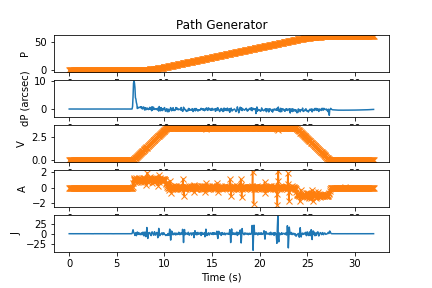

In [28]:
plot_path_generator(data, acceleration, jerk, time_operation)

Check the data with a wider range.

In [108]:
time_start = Time("2022-05-20T16:54:40", scale="utc", format="isot")
time_end = Time("2022-05-20T17:00:10", scale="utc", format="isot")

In [109]:
data, acceleration, jerk, time_operation = await get_data_path_generator(efd_client, time_start, time_end)

Units: P (deg), dP (arcsec), V (deg/s), A (deg/s^2), J (deg/s^3)


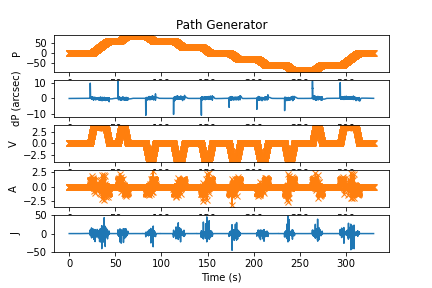

In [110]:
plot_path_generator(data, acceleration, jerk, time_operation)

Check the inPosition event.

In [111]:
data_controller_state, data_in_position, data_tracking = await get_event_data(efd_client, time_start, time_end)

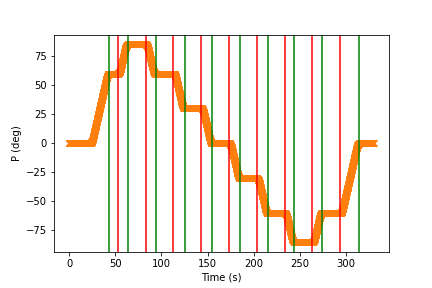

In [120]:
plot_event_in_position(data, time_operation, data_in_position)

**Tracking**

Check the tracking without the initial slewing.

In [142]:
time_start = Time("2022-05-20T19:38:00", scale="utc", format="isot")
time_end = Time("2022-05-20T19:38:15", scale="utc", format="isot")

In [143]:
data, acceleration, jerk, time_operation = await get_data_path_generator(efd_client, time_start, time_end)

Units: P (deg), dP (arcsec), V (deg/s), A (deg/s^2), J (deg/s^3)


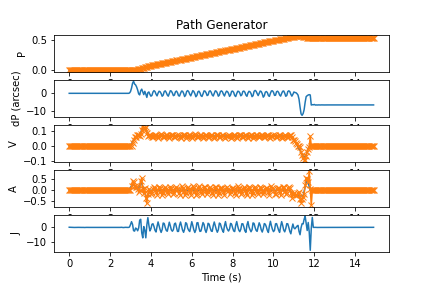

In [185]:
plot_path_generator(data, acceleration, jerk, time_operation)

In [186]:
data_controller_state, data_in_position, data_tracking = await get_event_data(efd_client, time_start, time_end)

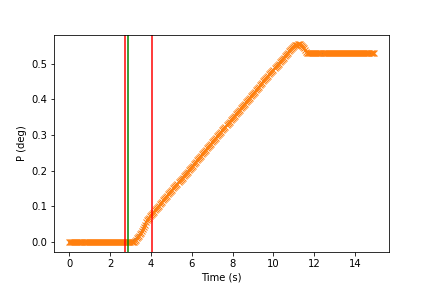

In [193]:
plot_event_in_position(data, time_operation, data_in_position)

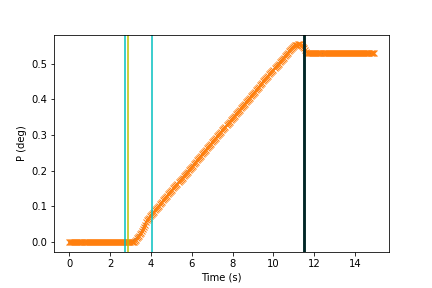

In [197]:
plot_event_tracking(data, time_operation, data_tracking)

Check the tracking with the initial slewing (positive direction).

In [219]:
time_start = Time("2022-05-20T19:07:39", scale="utc", format="isot")
time_end = Time("2022-05-20T19:08:05", scale="utc", format="isot")

In [220]:
data, acceleration, jerk, time_operation = await get_data_path_generator(efd_client, time_start, time_end)

Units: P (deg), dP (arcsec), V (deg/s), A (deg/s^2), J (deg/s^3)


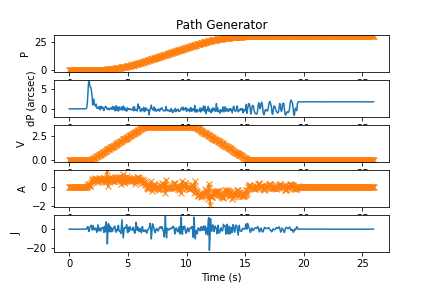

In [226]:
plot_path_generator(data, acceleration, jerk, time_operation)

In [222]:
data_controller_state, data_in_position, data_tracking = await get_event_data(efd_client, time_start, time_end)

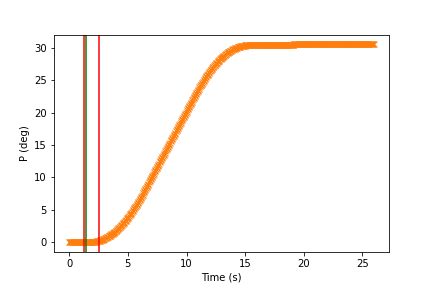

In [229]:
plot_event_in_position(data, time_operation, data_in_position)

In [224]:
data_in_position

,inPosition,time_difference
2022-05-20 19:07:40.287000+00:00,False,1.287
2022-05-20 19:07:40.437000+00:00,True,1.437
2022-05-20 19:07:41.538000+00:00,False,2.538


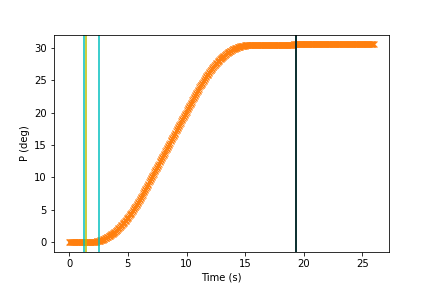

In [228]:
plot_event_tracking(data, time_operation, data_tracking)

In [227]:
data_tracking

,tracking,lost,noNewCommand,time_difference
2022-05-20 19:07:40.287000+00:00,False,True,False,1.287
2022-05-20 19:07:40.437000+00:00,True,True,False,1.437
2022-05-20 19:07:41.538000+00:00,False,True,False,2.538
2022-05-20 19:07:58.292000+00:00,False,False,True,19.292


Check the tracking with the initial slewing (negative direction).

In [235]:
time_start = Time("2022-05-20T19:20:00", scale="utc", format="isot")
time_end = Time("2022-05-20T19:20:25", scale="utc", format="isot")

In [236]:
data, acceleration, jerk, time_operation = await get_data_path_generator(efd_client, time_start, time_end)

Units: P (deg), dP (arcsec), V (deg/s), A (deg/s^2), J (deg/s^3)


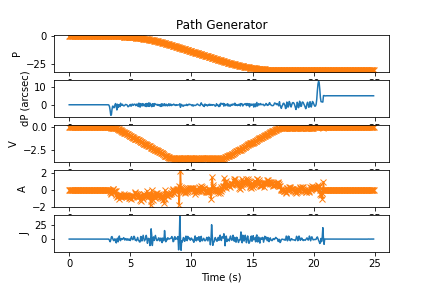

In [238]:
plot_path_generator(data, acceleration, jerk, time_operation)

**Tracking + Slewing**

In [279]:
time_start = Time("2022-05-20T19:30:10", scale="utc", format="isot")
time_end = Time("2022-05-20T19:35:20", scale="utc", format="isot")

In [280]:
data, acceleration, jerk, time_operation = await get_data_path_generator(efd_client, time_start, time_end)

Units: P (deg), dP (arcsec), V (deg/s), A (deg/s^2), J (deg/s^3)


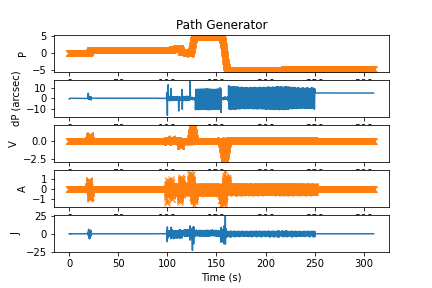

In [281]:
plot_path_generator(data, acceleration, jerk, time_operation)

In [282]:
data_controller_state, data_in_position, data_tracking = await get_event_data(efd_client, time_start, time_end)

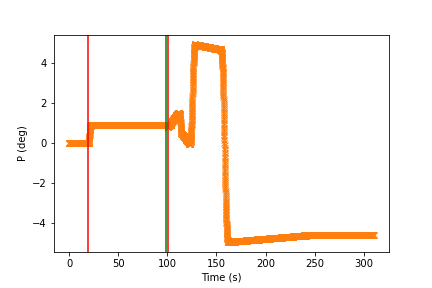

In [287]:
plot_event_in_position(data, time_operation, data_in_position)

In [288]:
data_in_position

,inPosition,time_difference
2022-05-20 19:30:29.192000+00:00,False,19.192
2022-05-20 19:31:49.010000+00:00,True,99.010
2022-05-20 19:31:50.160000+00:00,False,100.160


In [289]:
data_tracking

,tracking,lost,noNewCommand,time_difference
2022-05-20 19:30:29.192000+00:00,False,True,False,19.192
2022-05-20 19:30:31.942000+00:00,False,False,True,21.942
2022-05-20 19:31:34.406000+00:00,False,False,False,84.406
2022-05-20 19:31:48.860000+00:00,False,True,False,98.860
2022-05-20 19:31:49.010000+00:00,True,True,False,99.010
2022-05-20 19:31:50.160000+00:00,False,True,False,100.160
2022-05-20 19:31:52.061000+00:00,False,False,False,102.061
2022-05-20 19:31:53.111000+00:00,False,True,False,103.111
2022-05-20 19:34:20.147000+00:00,False,False,True,250.147
2022-05-20 19:35:16.110000+00:00,False,False,False,306.110


In [277]:
plt.close('all')